In [ ]:
# Import modules
from __future__ import print_function
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('Using GPU(0):', physical_devices[0])
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
else:
    print('Using CPU')

import numpy as np
from numpy.random import shuffle
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reload code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2
print(tf.__version__)

Using GPU(0): PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.17.1


In [ ]:
import tarfile
import os
import random
import shutil
from tensorflow.keras.utils import image_dataset_from_directory

# Step 1: Extract the dataset
dataset_tar_path = "tiny-imagenet-200.tar"
extract_dir = "tiny-imagenet-200"

if not os.path.exists(extract_dir):
    with tarfile.open(dataset_tar_path, "r:") as tar:
        tar.extractall()
    print("Dataset extracted.")

# Paths for train and validation directories
train_dir = os.path.join(extract_dir, "train")
val_dir = os.path.join(extract_dir, "val")

# Step 2: Randomly select 10 classes
all_classes = os.listdir(train_dir)
selected_classes = random.sample(all_classes, 10)
print(f"Selected classes: {selected_classes}")

# Create filtered directories
filtered_train_dir = "tiny-imagenet-10/train"
filtered_val_dir = "tiny-imagenet-10/val"

# Ensure fresh directories
if os.path.exists("tiny-imagenet-10"):
    shutil.rmtree("tiny-imagenet-10")
os.makedirs(filtered_train_dir)
os.makedirs(filtered_val_dir)

for class_name in selected_classes:
    # Copy training data
    src_train_class_dir = os.path.join(train_dir, class_name)
    dst_train_class_dir = os.path.join(filtered_train_dir, class_name)
    shutil.copytree(src_train_class_dir, dst_train_class_dir)

    # Copy validation data
    src_val_class_dir = os.path.join(val_dir, class_name)
    dst_val_class_dir = os.path.join(filtered_val_dir, class_name)
    shutil.copytree(src_val_class_dir, dst_val_class_dir)


Selected classes: ['n03977966', 'n02437312', 'n04275548', 'n02403003', 'n03937543', 'n01774750', 'n07873807', 'n02892201', 'n02074367', 'n03544143']


In [ ]:
import tensorflow as tf
import os
import shutil

data_dir = "tiny-imagenet-10"  # Folder name after extraction

# Get the list of all class directories in the training set
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomContrast
)

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.1),
])


# Step 3: Define preprocessing
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 8

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Step 4: Load the datasets
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',  # Labels are integers
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Found 5000 files belonging to 10 classes.


In [ ]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False
).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Test Dataset (if test labels exist)
# If no labels, use label_mode=None
try:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        label_mode=None,  # Set None if labels are not available
        batch_size=BATCH_SIZE,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle=False
    ).map(lambda x: tf.image.resize(x, [IMG_SIZE, IMG_SIZE]) / 255.0,
          num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
except Exception as e:
    test_ds = None
    print(f"No test dataset found: {e}")

# Step 5: Check dataset shapes
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape, labels.shape)
for images, labels in val_ds.take(1):
    print("Validation batch shape:", images.shape, labels.shape)

if test_ds:
    for images in test_ds.take(1):
        print("Test batch shape:", images.shape)

Found 500 files belonging to 10 classes.
No test dataset found: name 'test_dir' is not defined
Train batch shape: (8, 224, 224, 3) (8,)
Validation batch shape: (8, 224, 224, 3) (8,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

class Residual(layers.Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=9, patch_size=7, n_classes=1000):
    # Patch extraction
    layers_list = [
        layers.Conv2D(dim, kernel_size=patch_size, strides=patch_size, padding="valid"),
        layers.Activation("gelu"),
        layers.BatchNormalization()
    ]

    # ConvMixer blocks
    for _ in range(depth):
        layers_list.append(Sequential([
            Residual(Sequential([
                layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same"),
                layers.Activation("gelu"),
                layers.BatchNormalization()
            ])),
            layers.Conv2D(dim, kernel_size=1, padding="valid"),
            layers.Activation("gelu"),
            layers.BatchNormalization()
        ]))

    # Pooling and classification head
    layers_list.extend([
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dense(n_classes, activation="softmax")
    ])

    # Build the model
    return Sequential(layers_list)

In [ ]:
from utils.ConvMixerAdamW import ConvMixer

# Model parameters
dim = 512
depth = 8
kernel_size = 9
patch_size = 7
n_classes = 10

# Build and summarize the model
model = ConvMixer(dim=dim, depth=depth, kernel_size=kernel_size, patch_size=patch_size, n_classes=n_classes)
model.build(input_shape=(None, 224, 224, 3))  # Assuming 224x224 RGB images
model.summary()

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 32, 32, 512)         │          75,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_68 (Activation)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_44 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_46 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_48 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_50 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_52 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_54 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_56 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_58 (Sequential)           │ (None, 32, 32, 512)         │         308,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,552,842 (9.74 MB)

 Trainable params: 2,535,434 (9.67 MB)

 Non-trainable params: 17,408 (68.00 KB)

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Compile the ConvMixer model. Utilize the AdamW as the optimizer
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()]
)

In [ ]:
# Train the ConvMixer model
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 103ms/step - loss: 2.0528 - sparse_categorical_accuracy: 0.3049 - val_loss: 2.7166 - val_sparse_categorical_accuracy: 0.3860
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 100ms/step - loss: 1.4543 - sparse_categorical_accuracy: 0.4843 - val_loss: 1.9461 - val_sparse_categorical_accuracy: 0.4960
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - loss: 1.2020 - sparse_categorical_accuracy: 0.5782 - val_loss: 1.1512 - val_sparse_categorical_accuracy: 0.6300
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 98ms/step - loss: 1.0674 - sparse_categorical_accuracy: 0.6326 - val_loss: 1.0774 - val_sparse_categorical_accuracy: 0.6540
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - loss: 0.9205 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.9476 - val_sparse_categorical_accuracy: 0.6880
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - loss: 0.8165 - sparse_categorical_accuracy: 0.7187 - val_loss: 1.0363 - val_sparse_categorical_accur

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.9796 - sparse_categorical_accuracy: 0.7640
Validation Loss: 0.9811
Validation Accuracy: 76.4000%


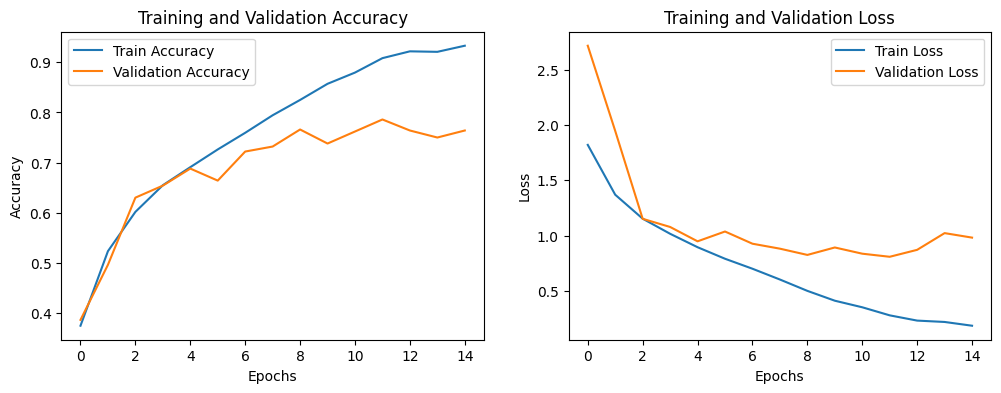

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()